Import our libraries, sklearn is a must!

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 15)

Load in our Amazon review data. The only features we're interested in for this are the text of the review and its title.

We also want the rating for our labels.

In [2]:
data = pd.read_csv("Amazon-Reviews.csv")
data = data.loc[:, ['reviews.text', 'reviews.title', 'reviews.rating']]
data

,reviews.text,reviews.title,reviews.rating
0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",5.0
1,Allow me to preface this with a little history...,One Simply Could Not Ask For More,5.0
2,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,4.0
3,I bought one of the first Paperwhites and have...,Love / Hate relationship,5.0
4,I have to say upfront - I don't like coroporat...,I LOVE IT,5.0
5,"My previous kindle was a DX, this is my second...",Great device for reading. 8 people found this ...,NaN
6,Allow me to preface this with a little history...,One Simply Could Not Ask For More 28 people fo...,NaN
...,...,...,...
1590,Voice remote gave out nearly a year after I pu...,"OEM Remote gave out after 12 months, consideri...",1.0
1591,Purchased my first one with the TV Fire box ov...,My voice remote controller pooed out,2.0


This dataset has some messy rows, not all reviews carry a star rating, let's remove all rows with NaN ratings.

In [3]:
data = data.dropna(thresh=0)
data = data[np.isfinite(data['reviews.rating'])]
data

,reviews.text,reviews.title,reviews.rating
0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",5.0
1,Allow me to preface this with a little history...,One Simply Could Not Ask For More,5.0
2,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,4.0
3,I bought one of the first Paperwhites and have...,Love / Hate relationship,5.0
4,I have to say upfront - I don't like coroporat...,I LOVE IT,5.0
13,"Had older model, that you could text to speech...",Liked the smaller size,4.0
14,This is a review of the Kindle Paperwhite laun...,Superb reading device - but which one's best f...,5.0
...,...,...,...
1590,Voice remote gave out nearly a year after I pu...,"OEM Remote gave out after 12 months, consideri...",1.0
1591,Purchased my first one with the TV Fire box ov...,My voice remote controller pooed out,2.0


Let's see how even our labels are in the data set

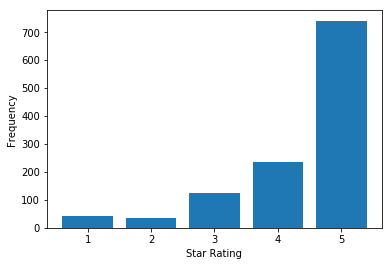

In [4]:
dist = data.groupby('reviews.rating').count().loc[:, ['reviews.text']].as_matrix()
plt.bar(range(1,6), dist)
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.show()

The reviews are very heavily weighted towards higher ratings, may need to over/undersample.

This is a problem in real data science problems. Suppose we were designing a medical model to detect whether a person has a type of rare cancer. This cancer could be present in 0.1% of people, meaning a model that always predicts negative would have an accuracy of 99.9%!... but we would misdiagnose ill people.

To prevent this sort of imbalance we can artificially boost our training set to have even samples:

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


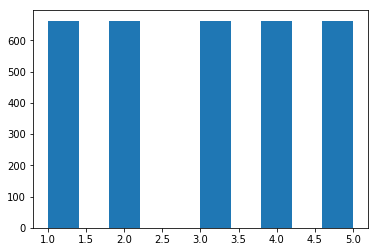

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

text = np.squeeze(data.loc[:, ['reviews.text']].as_matrix())
title = np.squeeze(data.loc[:, ['reviews.title']].as_matrix())
label = data.loc[:, ['reviews.rating']].as_matrix().reshape(-1)
text_vectoriser = CountVectorizer()
title_vectoriser = CountVectorizer()
text_vector = text_vectoriser.fit_transform(text)
title_vector = title_vectoriser.fit_transform(title)
X = np.concatenate((title_vector.todense(), text_vector.todense()), axis=1)
b = np.ones((1177, 1))
X = np.concatenate((X, b), axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, label, test_size=0.1)

sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

plt.hist(y_train_res)
plt.show()

y_train_res = (np.arange(y_train_res.max()) == y_train_res[:, None]-1).astype(int) #Convert rating into one hot encoding
y_test = (np.arange(y_test.max()) == y_test[:, None]-1).astype(int)

We now have an even ~650 examples for each star rating. If you're curious as to how this was done, here is the paper on the SMOTE algorithm:
https://www.jair.org/media/953/live-953-2037-jair.pdf

Next we have our helper functions:

In [6]:
def activate(Q): #A sigmoid
    return 1/(1+np.exp(-Q))

In [7]:
def calc_error(D, Y): #Mean squared error
    return (0.5*np.sum(np.square(D-Y)))/len(D)

In [8]:
#This is our training algorithm, the real bulk of which is just the three
#lines just inside the for loop, the rest is just extra fluff for visualisation
def train_perceptron(X, D, n_epochs, eta, x_test=None, y_test=None):
    W = np.random.uniform(-1, 1, (X.shape[1], D.shape[1]))
    errors = []
    test_errors = []
    for epoch in range(n_epochs):
        Y = activate(np.dot(X, W))
        W += eta*np.dot(((D-Y).T), X).T
        error = calc_error(D, Y)
        errors.append(error)
        #If the test data is supplied, calculate test error too
        if x_test is not None:
            d_test = use_perceptron(x_test, W)
            test_error = calc_error(d_test, y_test)
            test_errors.append(test_error)
    print('Done!')
    
    plt.plot(errors)
    plt.plot(test_errors)
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.show()
    
    return W

#Method that lets us use a trained perceptron for predicting on future data
def use_perceptron(X, W):
    return activate(np.dot(X, W))

Next we can actually train a perceptron! This method will kick up a small fuss about overflows but is nothing to worry about, it's just the sigmoid having to compute on large values.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Done!


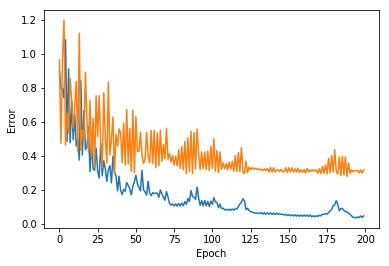

In [10]:
n_epochs = 200 #How long to train the network, try adjusting this number! (>200 can take a few seconds)
eta = 0.11 #Our "step size", how big of a step do we take down the hill? Adjust this number too!
W = train_perceptron(x_train_res, y_train_res, n_epochs, eta, x_test=x_test, y_test=y_test)

The blue line is our error on our training set, the orange is our error on our testing set.

You'll notice training is rapid to begin with and smooths out as we reach a local minimum in our hilly space.

Next let's take our testing data and work out our F1 score. If you need a reminder on that then look here:
https://en.wikipedia.org/wiki/F1_score
Think of it as the average of precision and recall

![PR.svg](https://en.wikipedia.org/wiki/Precision_and_recall#/media/File:Precisionrecall.svg)

In [11]:
test_predictions = use_perceptron(x_test, W)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [12]:
from sklearn.metrics import confusion_matrix, f1_score
y_test_argmax = np.argmax(y_test, axis=1)
test_predictions_argmax = np.argmax(test_predictions, axis=1)
confusion_matrix(y_test_argmax, test_predictions_argmax)

array([[ 1,  0,  2,  0,  1],
       [ 1,  0,  1,  0,  1],
       [ 1,  1,  8,  3,  1],
       [ 0,  1,  4,  9,  5],
       [ 2,  1,  6, 12, 57]])

In [13]:
f1 = f1_score(y_test_argmax, test_predictions_argmax, average='weighted')
print(f1)

0.656137249515


Next we can take some new unseen data and see what our model thinks of it, you can edit this data and see what happens to the predictions. Note: this model is very simplistic and can have some strange predictions. Also it can only operate on words it saw in the training data so be gentle

In [14]:
title_neg = 'Terrible'
text_neg = 'The worst ive ever bought'

title_pos = 'Brilliant'
text_pos = 'The best ive ever bought'

In [15]:
def vectorise(title, text):
    title_vector = title_vectoriser.transform(np.array([title]).ravel())
    text_vector = text_vectoriser.transform(np.array([text]).ravel())
    review_vector = np.concatenate((title_vector.todense(), text_vector.todense()), axis=1)
    b = np.ones((1, 1))
    X = np.concatenate((review_vector, b), axis=1)
    return X

In [16]:
pos_vec = vectorise(title_pos, text_pos)
neg_vec = vectorise(title_neg, text_neg)

In [17]:
W = pickle.load(open('0.71055323893_F1.p', 'rb')) #Load a decent pre-trained model
classification = use_perceptron(pos_vec, W)
print(title_pos, '-', text_pos, ':', str(np.argmax(classification)+1)+" star(s)")
classification = use_perceptron(neg_vec, W)
print(title_neg, '-', text_neg, ':', str(np.argmax(classification)+1)+" star(s)")

Brilliant - The best ive ever bought : 5 star(s)
Terrible - The worst ive ever bought : 2 star(s)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
